# People Chart Dataset Preparing of SapJam Topic "Blockchain"
Dataset file: People entities generate nodes and links

In [128]:
import json
import numpy as np
import pandas as pd

from pandas import DataFrame
from sqlalchemy import create_engine, distinct
from sqlalchemy.orm import sessionmaker

from JamScrapy import config
from JamScrapy.preprocess.entity import Profile, People

In [129]:
TOPIC_KEYWORD = 'Blockchain'
POSTS_THRESHOLD = 5
LINKS_THRESHOLD = 20
DEGREE_THREHOLD = 5

engine = create_engine(config.DB_CONNECT_STRING, max_overflow=5)

## 1. Dataset Preparing
### 1.1 Get Profiles by certain topic

In [130]:
sql = f'''select profile.* from (select displayname from jam_people_from_post
where keyword='{TOPIC_KEYWORD}' and roletype='Creator' and jam_people_from_post.displayname <> 'Alumni' 
group by jam_people_from_post.displayname having count(postid) >= {POSTS_THRESHOLD}) as people inner join jam_profile as profile
on people.displayname = profile.displayname'''

profiles = engine.execute(sql).fetchall()

print("profiles:", len(profiles))

#Jack Wang
#Swati Singh

profiles: 669


### 1.2 Get top contribution people

In [131]:
df_contribution = pd.read_csv(filepath_or_buffer=f'./output/contributes-{TOPIC_KEYWORD}.csv')

print(df_contribution.index)
print(df_contribution.columns)
print(df_contribution.shape)
df_contribution.describe(exclude=[np.object]).astype(np.int64).T

RangeIndex(start=0, stop=639, step=1)
Index(['Unnamed: 0', 'author', 'posts', 'comments', 'likes', 'views',
       'posts_trans', 'comments_trans', 'likes_trans', 'views_trans',
       'contribution'],
      dtype='object')
(639, 11)


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,639,319,184,0,159,319,478,638
posts,639,13,18,5,6,8,13,288
comments,639,14,22,0,6,9,14,340
likes,639,8,40,0,0,1,5,820
views,639,904,3406,3,88,220,625,51986
posts_trans,639,2,0,1,1,2,2,5
comments_trans,639,2,0,0,1,2,2,5
likes_trans,639,0,1,0,0,0,1,6
views_trans,639,5,1,1,4,5,6,10
contribution,639,48,12,0,39,47,56,100


## 2. Generate chart links

In [132]:
def add_link(list, filters, str, source=None, target=None, ban=False):
    if str:
        jsons = json.loads(str)
        if not ban or ban and (len(jsons) < LINKS_THRESHOLD):
            for item in jsons:
                name = item['name']               
                if (name in filters) and (name not in ['Francis Lui']):
                    if source is not None:
                        list.append({"source": source, "target": name})
                    elif target is not None:
                        list.append({"source": name, "target": target})

In [133]:
filters = [p.displayname for p in profiles]

links = []
for p in profiles:
    add_link(links, filters, p.managers, target=p.displayname)
    add_link(links, filters, p.reports, source=p.displayname)
    add_link(links, filters, p.followers, target=p.displayname, ban=True)
    add_link(links, filters, p.following, source=p.displayname, ban=True)

# 去掉重复节点
links = [dict(t) for t in set([tuple(d.items()) for d in links])]

print(len(links))

with open("./output/links.json",'w',encoding='utf-8') as json_file:
    json.dump(links,json_file,ensure_ascii=False)

543


In [134]:
nodes_degree = dict()

for l in links:
    if l['source'] not in nodes_degree:
        nodes_degree[l['source']] = 1
    else:
        nodes_degree[l['source']] += 1

    if l['target'] not in nodes_degree:
        nodes_degree[l['target']] = 1
    else:
        nodes_degree[l['target']] += 1
        
print(len(nodes_degree))

399


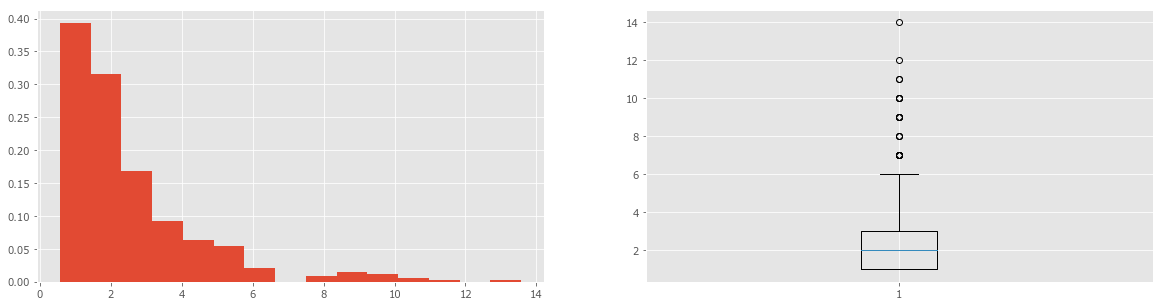

In [135]:
import matplotlib.pyplot as plt

degree = [v for v in nodes_degree.values()]

fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.hist(degree, bins=15, align='left', normed=True)
ax2.boxplot(degree)

plt.show()

## 3. Generate chart nodes

In [136]:
BROKERS = ['Timo ELLIOTT','Joerg Koesters','Melanie Fiolka','ernesto Morales','Soon Fuller','Dante Ricci','Raimund Gross','Charles Tigges','Monica Gassmann','Joerg Ferchow','Simon Cummings','Maarten de Vries']
INFLUENCERS = ['Dae Young Chung','Bob Leeds','Aman Chauhan','Maren Heilig','Subhankar Pattanayak','Andy Rubinson','Shantanu Garg','Marlyn Zelkowitz','Stefanie Schneider','Georg Kube','Benjamin Stoeckhert']

In [137]:
nodes = []

for p in profiles:
    # 设置value和节点大小，依据contribution
    value = 0
    symbol_size = 5
    
    item = df_contribution[df_contribution['author']==p.displayname]    
    if item.size > 0:
        value = round(float(item['contribution']),2)
        symbol_size = 5+int(item['contribution']/6)
        
    # 设置category，依据degree
    categroy = 0
    
    if p.displayname in nodes_degree:
        if p.displayname in BROKERS:
            categroy = 3
        elif p.displayname in INFLUENCERS:
            categroy = 2
        elif nodes_degree[p.displayname] >= DEGREE_THREHOLD:
            categroy = 1
           
    nodes.append({"name": p.displayname, "value": value, "symbolSize": symbol_size, "category": categroy})

# 去掉重复节点
nodes = [dict(t) for t in set([tuple(d.items()) for d in nodes])]

print(len(nodes))

with open("./output/nodes.json",'w',encoding='utf-8') as json_file:
    json.dump(nodes,json_file, ensure_ascii=False)

667


In [138]:
matrix = dict()
threshold = 62 # threshold: 74.77380738649151 62.160711079737254

for item in nodes:   
    if item['category'] == 0 and item['value'] <= threshold:
        character = "Thinkers"
    elif item['category'] == 0 and item['value'] > threshold:
        character = "Pioneers"
    elif item['category'] == 1 and item['value'] <= threshold:
        character = "Delegators"
    elif item['category'] == 1 and item['value'] > threshold:
        character = "Generators"
    elif item['category'] == 2 and item['value'] <= threshold:
        character = "Enablers"
    elif item['category'] == 2 and item['value'] > threshold:
        character = "Teamsters"
    elif item['category'] == 3 and item['value'] <= threshold:
        character = "Broadcasters"
    elif item['category'] == 3 and item['value'] > threshold:
        character = "Definers"

    if character not in matrix:
        matrix[character] = 1
    else:
        matrix[character] += 1

print('Thinkers', matrix['Thinkers'], 'Pioneers', matrix['Pioneers'])
print('Delegators', matrix['Delegators'], 'Generators', matrix['Generators'])
print('Enablers', matrix['Enablers'], 'Teamsters', matrix['Teamsters'])
print('Broadcasters', matrix['Broadcasters'], 'Definers', matrix['Definers'])

Thinkers 522 Pioneers 81
Delegators 31 Generators 10
Enablers 8 Teamsters 3
Broadcasters 8 Definers 4


# 4. Generate Nodes group by division

In [139]:
FIELD_GROUP_BY = 'boardarea'
data_view = f'''select profile.*, p_profile.{FIELD_GROUP_BY} from (select displayname from jam_people_from_post
where keyword='{TOPIC_KEYWORD}' and roletype='Creator' and jam_people_from_post.displayname <> 'Alumni'
group by jam_people_from_post.displayname having count(postid) >= {POSTS_THRESHOLD}) as people
inner join jam_profile as profile on people.displayname = profile.displayname
inner join portal_profile as p_profile on profile.username = p_profile.username'''
sql = f'''select {FIELD_GROUP_BY}, count(id) from ({data_view}) as t group by t.{FIELD_GROUP_BY} order by t.{FIELD_GROUP_BY}'''

In [140]:
results = engine.execute(sql).fetchall()

print(results)

[(None, 27), ('Cloud Business Group', 111), ('Digital Business Services', 68), ('Finance & Administration', 2), ('Global Business Operations', 15), ('Global Customer Operations', 188), ('Human Resources', 8), ('Office of CEO', 150), ('Products & Innovation', 99)]


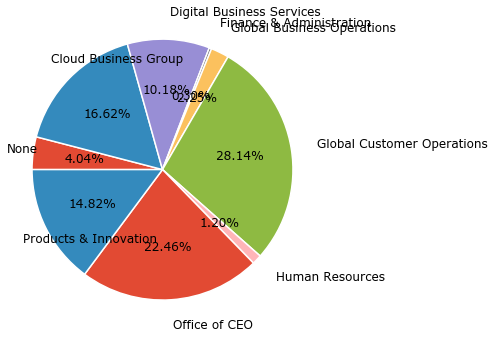

In [141]:
from utility import plt_pie

values = []
labels = []
for r in results:
    if int(r[1]) > 0:
        values.append(int(r[1]))
        labels.append(r[0])
        
plt_pie(values, labels)

In [142]:
profiles = engine.execute(data_view+f' order by {FIELD_GROUP_BY}').fetchall()

print(len(profiles))

668


In [153]:
nodes = []

for p in profiles:
    if (p.displayname in nodes_degree.keys()):
        # 设置value和节点大小，依据contribution
        value = 0
        symbol_size = 5
        
        item = df_contribution[df_contribution['author']==p.displayname]
        if item.size > 0:
            value = round(float(item['contribution']),2)
            symbol_size = 5+int(item['contribution']/6)
        
        if p.boardarea == None:
            nodes.append({"name": p.displayname, "value": value, "symbolSize": symbol_size, "category": 'None'})
        else:
            nodes.append({"name": p.displayname, "value": value, "symbolSize": symbol_size, "category": p.boardarea})

# 去掉重复节点
nodes = [dict(t) for t in set([tuple(d.items()) for d in nodes])]
nodes.remove({'name': 'Jack Wang', 'value': 55.74, 'symbolSize': 14, 'category': 'Products & Innovation'})

nodes.sort(key = lambda x:x["category"])

print(len(nodes))

with open("./output/nodes-division.json",'w',encoding='utf-8') as json_file:
    json.dump(nodes,json_file, ensure_ascii=False)

399


In [154]:
for p in nodes:
    if p['name'] in ['Jack Wang','Swati Singh']:
        print(p)

{'name': 'Jack Wang', 'value': 55.74, 'symbolSize': 14, 'category': 'Global Customer Operations'}
{'name': 'Swati Singh', 'value': 57.93, 'symbolSize': 14, 'category': 'Office of CEO'}
